In [ ]:
import sys

sys.path.append('/Users/adam.santorelli/lib/pygt3x/')
sys.path.append('/Users/adam.santorelli/lib/')
sys.path.append('/Users/adam.santorelli/lib/wristpy/src/actigrapy/common/')
sys.path.append('/Users/adam.santorelli/lib/wristpy/src/actigrapy/io/')
sys.path.append('/Users/adam.santorelli/lib/wristpy/src/actigrapy/ggir/')

import calendar
import os
from datetime import datetime, timedelta
from typing import Any

import numpy as np
import pandas as pd
import polars as pl



In [ ]:
file_name = '/Users/adam.santorelli/Documents/NDARAA948VFH.gt3x'


In [ ]:
import data_model

In [ ]:
test_config = data_model.Config(file_name, file_name)

In [ ]:
test_config.path_input

In [ ]:
sys.path.append('/Users/adam.santorelli/lib/wristpy/src/actigrapy/io/loaders')
import gt3x

In [ ]:
test_data = gt3x.load(test_config.path_input)

In [ ]:
test_data.time

In [111]:
import metrics_calc

In [148]:
ws = 10
min_hours = 72

In [375]:
from warnings import warn

accel_data = test_data.acceleration
time_data = test_data.time
s_r = test_data.sampling_rate

n10 = int(10 * s_r)  # samples in 10 seconds, not used because hardcoded 10s
nh = int(min_hours* 3600 * s_r)  # samples in min_hours
n12h = int(12 * 3600 * s_r)  # samples in 12 hours

i_h = 0  # keep track of number of extra 12 hour blocks used

    # check if enough data
if accel_data.height < nh:
        warn(
            f"Less than {min_hours} hours of data ({accel_data.height / (s_r * 3600)} hours). "
            f"No Calibration performed",
            UserWarning,
        )



In [376]:
    # trim accel data
#i_h += 1
accel_data_trimmed = accel_data[: nh + i_h * n12h]
time_data_trimmed = time_data[: nh + i_h * n12h]

In [377]:
RM = metrics_calc.moving_mean(accel_data_trimmed, time_data_trimmed, s_r, 10)
acc_rm = RM.select(['X_mean','Y_mean','Z_mean'])

RSD = metrics_calc.moving_std(accel_data_trimmed, time_data_trimmed, s_r, 10)
acc_rsd = RSD.select(['X_std','Y_std','Z_std'])

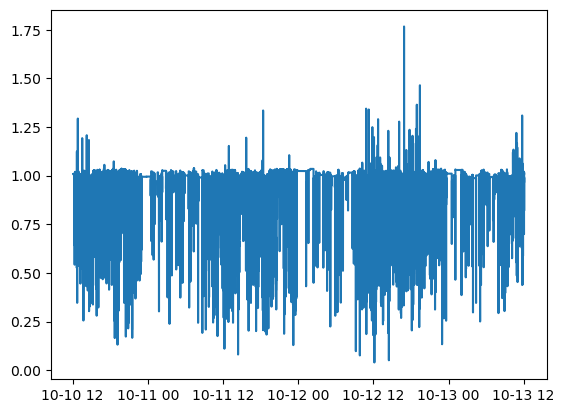

In [379]:
from matplotlib import pyplot as plt
#plt.plot(test_data.time, accel_data['X'])
plt.plot(RM['window_start'], np.linalg.norm(acc_rm, axis=1))
plt.show()

In [380]:
import sklearn.linear_model

In [381]:
sd_crit = 0.013
no_motion = np.all(acc_rsd < sd_crit, axis=1) & np.all(np.abs(acc_rm) < 2, axis=1)

In [382]:
acc_rm_nm = acc_rm.filter(no_motion)
acc_rsd_nm = acc_rsd.filter(no_motion)

In [383]:

tel = 0
for col in acc_rm_nm.columns:
    tmp = (acc_rm_nm[col].min()< -0.3) & (acc_rm_nm[col].max() > 0.3)
    if tmp:
        tel = tel+1

In [384]:
cal_err_start = np.round(np.mean(abs(np.linalg.norm(acc_rm_nm, axis=1) - 1)), decimals=5)

In [173]:
from sklearn.linear_model import LinearRegression

In [385]:
offset = pl.Series(np.zeros(3))
scale = pl.Series(np.ones(3).flatten())
tmp_scale = np.zeros((1, 3))

weights = np.ones(acc_rm_nm.shape[0]) * 100
res = [np.Inf]
LR = LinearRegression()

In [386]:
##Method 1
acc_nm_pd = acc_rm_nm.to_pandas()
curr = (acc_nm_pd* scale) + offset

In [301]:
## Method 2
scale = np.ones(3).reshape(3,1)
check = acc_rm_nm.select([
    (pl.col(column_name) * scale[i] + offset[i]).alias(column_name)
    for i, column_name in enumerate(acc_rm_nm.columns)
    ])
check_pd = check.to_pandas()


In [387]:
max_iter = 1000
tol = 1e-10
weights = np.ones(curr.shape[0]) * 100
res = [np.Inf]

for i in range(max_iter): 
    curr = (acc_nm_pd * scale) + offset
    closest_point = curr / np.linalg.norm(curr, axis=1, keepdims=True)
    offsetch = np.zeros(3)
    scalech = np.ones(3)
    
    for k in range(3):
                # there was some code dropping NANs from closest point, but these should
                # be taken care of in the original mask. Division by zero should also
                # not be happening during motionless data, where 1 value should always be close
                # to 1
        x_ = np.vstack(
                    (curr.iloc[:, k])
                )  
        tmp_y = np.vstack(
                    (closest_point.iloc[:, k])
                )
        LR.fit(x_, tmp_y, sample_weight=weights)

        offsetch[k] = LR.intercept_
        scalech[k] = LR.coef_[0]
        curr.iloc[:, k] = x_ @ LR.coef_
    
    scale = scalech * scale
    offset = offsetch + (offset/scale)
    res.append(3 * np.mean(weights[:, None] * (curr - closest_point) ** 2 / weights.sum()))
    weights = np.minimum(1 / np.linalg.norm(curr - closest_point, axis=1), 100)

    if abs(res[i] - res[i - 1]) < tol:
        break
    
print(scale, offset, res)


shape: (3,)
Series: '' [f64]
[
	1.000222
	0.99345
	1.002266
] shape: (3,)
Series: '' [f64]
[
	-0.000775
	-0.021801
	0.008667
] [inf, 2.4388227054612412e-08, 1.0193514324170875e-08, 9.213381842168493e-09, 8.506831694059638e-09, 8.055885203535174e-09, 7.734642891471814e-09, 7.480847832295595e-09, 7.270695583134879e-09, 7.096054266826928e-09, 6.950140987818829e-09, 6.827554271913233e-09, 6.72490463403471e-09, 6.6380051077683075e-09, 6.5646733813322075e-09]


In [388]:

acc_cal_pd = (acc_nm_pd* scale) + offset

cal_error_end = np.around(np.mean(abs(np.linalg.norm(acc_cal_pd, axis=1) - 1)), decimals=5)
cal_error_end

0.00763

In [389]:
accel_cal_pd = (accel_data.to_pandas() * scale) + offset

In [390]:
## Method 2
accel_cal = accel_data.select([
    (pl.col(column_name) * scale[i] + offset[i]).alias(column_name)
    for i, column_name in enumerate(accel_data.columns)
    ])

In [391]:
tmp = accel_cal_pd-accel_data.to_pandas()

In [1]:
plt.plot(tmp['X'])
plt.show()

NameError: name 'plt' is not defined